# 0. Libraries and requirements

In [1]:
import sys
import os
import requests
import tarfile
import pickle
import collections
import time

import numpy as np
import pandas as pd

from skimage.feature import hog

from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline

from keras.models import Model
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.layers import Input, AveragePooling2D, MaxPooling2D

from cv2 import resize

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
print('Requirements:')
print('\nPython==' + sys.version[:5])
modules = !pip freeze
for module in ['numpy', 'pandas', 'scikit-image', 'scikit-learn', 
               'Keras', 'tensorflow-gpu', 'opencv-python']:
    for installed_module in modules:
        if module in installed_module:
            print(installed_module)

Requirements:

Python==3.6.3
numpy==1.14.5
pandas==0.23.1
scikit-image==0.14.0
scikit-learn==0.19.1
Keras==2.1.6
tensorflow-gpu==1.8.0
opencv-python==3.4.1.15


# 1. Download and process data

### CIFAR-10 dataset

[CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) consists of 60000 32x32 RGB images of 10 classes:

- airplane 										
- automobile 										
- bird 										
- cat 										
- deer 										
- dog 										
- frog 										
- horse 										
- ship 										
- truck

Images are splitted into training and test set respectively of 50000 and 10000 images. Each class contains 6000 images.

Thanks to access to 12-thread PC with CUDA-enabled GPU all data was used in this exercise. 

In [3]:
def download_data(url, filename):
    if os.path.exists(filename):
        print('CIFAR-10 data is already downloaded.')
        return
    url_data = requests.get(url, stream=True)
    file_size_bytes = int(url_data.headers['content-length'])
    downloaded_size_bytes = 0
    with open(filename, "wb") as f:
            for data in url_data.iter_content(chunk_size=10240):
                f.write(data)
                downloaded_size_bytes += len(data)
                downloaded_proc = 100 * downloaded_size_bytes / file_size_bytes
                sys.stdout.write("\r%d/%d bytes downloaded, %.1f" % 
                                 (downloaded_size_bytes, file_size_bytes, downloaded_proc) + '% done')
                sys.stdout.flush()
    return
                
def untar(filename, folder):
    tar = tarfile.open(filename)
    tar.extractall(folder)
    tar.close()
    return
                
def unpickle(filename):
    with open(filename, 'rb') as f:
        data_dict = pickle.load(f, encoding='bytes')
        data_dict_decoded = {}
        for key, value in data_dict.items():
            data_dict_decoded[key.decode('utf8')] = value
        data_dict = data_dict_decoded
    return data_dict

def load_batch(filename):
    data_dict = unpickle(filename)
    data = data_dict['data']
    labels = data_dict['labels']
    data = data.reshape(data.shape[0], 3, 32, 32)
    data = data.transpose(0, 2, 3, 1) #channels in tensorflow are last
    return data, labels

def load_classes_names(folder):
    with open(os.path.join(folder, 'batches.meta'), "rb") as f:
        batches_meta = pickle.load(f, encoding='bytes')
    classes_names = [class_name.decode('utf8') for class_name in batches_meta[b'label_names']]
    return classes_names

def load_data(folder):
    X_train = np.empty((50000, 32, 32, 3), dtype='uint8')
    y_train = np.empty((50000,), dtype='uint8')
    for i in np.arange(5):
        filename = os.path.join(folder, 'data_batch_' + str(i + 1))
        (X_train[i * 10000 : (i + 1) * 10000, :, :, :], y_train[i * 10000 : (i + 1) * 10000]) = load_batch(filename)
    filename = os.path.join(folder, 'test_batch')
    X_test, y_test = load_batch(filename)
    classes_names = load_classes_names(folder)
    return X_train, y_train, X_test, y_test, classes_names

In [4]:
url = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
filename = './data/cifar-10-python.tar.gz'
if not os.path.exists('./data'):
    os.makedirs('./data')
download_data(url, filename)
untar(filename, './data')

170498071/170498071 bytes downloaded, 100.0% done

In [5]:
data_folder = './data/cifar-10-batches-py/'
X_train, y_train, X_test, y_test, classes_names = load_data(data_folder)

In [6]:
collections.Counter(y_train), collections.Counter(y_test)

(Counter({6: 5000,
          9: 5000,
          4: 5000,
          1: 5000,
          2: 5000,
          7: 5000,
          8: 5000,
          3: 5000,
          5: 5000,
          0: 5000}),
 Counter({3: 1000,
          8: 1000,
          0: 1000,
          6: 1000,
          1: 1000,
          9: 1000,
          5: 1000,
          7: 1000,
          4: 1000,
          2: 1000}))

### Note

If we don't want to write own code, we can download and load data with 2 lines:

```{python}
from keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
```

# 2. 10 random images from each class

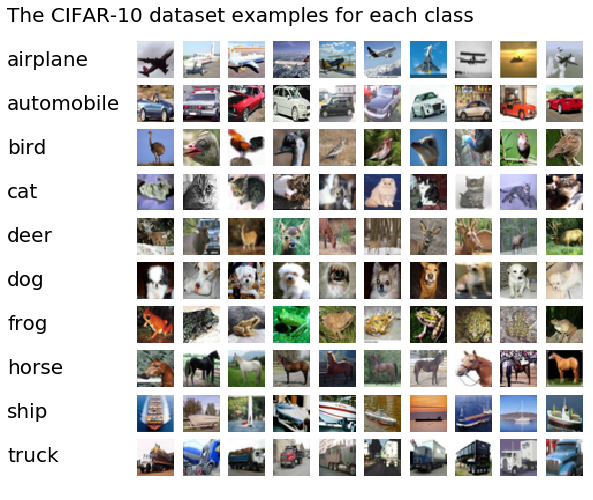

In [7]:
fig, axes = plt.subplots(10, 10, figsize=(8, 8))
for i in np.unique(y_train):
    for j in np.arange(10):
        k = np.random.choice(np.where(y_train == i)[0])
        axes[i, j].set_axis_off()
        axes[i, j].imshow(X_train[k])
fig.suptitle('The CIFAR-10 dataset examples for each class\n\nairplane\n\nautomobile' + 
             '\n\nbird\n\ncat\n\ndeer\n\ndog\n\nfrog\n\nhorse\n\nship\n\ntruck', 
             x=-0.1, y=0.94, horizontalalignment='left', fontsize=20)
plt.show()

# 3. Shallow classifier

First of all, we will train a shallow classifier which will serve as a benchmark for classifiers built on the top of the CNN Codes. We will use HoG descriptor for feature extraction and a SVM for classification.

In [8]:
def extract_feature(image, visualize=False):
    return hog(image, 
               orientations=9, 
               pixels_per_cell=(8, 8),
               cells_per_block=(2, 2),
               block_norm='L2-Hys',
               visualize=visualize,
               multichannel=True)

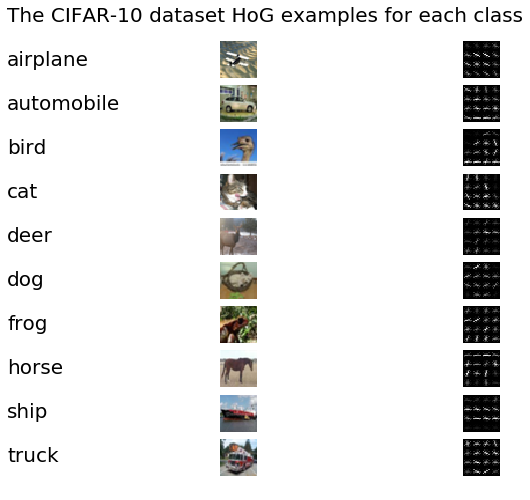

In [9]:
fig, axes = plt.subplots(10, 2, figsize=(8, 8))
for i in np.unique(y_train):
    k = np.random.choice(np.where(y_train == i)[0])
    axes[i, 0].set_axis_off()
    axes[i, 0].imshow(X_train[k])
    axes[i, 1].set_axis_off()
    fd, hog_image = extract_feature(X_train[k], visualize=True)
    axes[i, 1].imshow(hog_image, cmap='gray')
fig.suptitle('The CIFAR-10 dataset HoG examples for each class\n\nairplane\n\nautomobile' + 
             '\n\nbird\n\ncat\n\ndeer\n\ndog\n\nfrog\n\nhorse\n\nship\n\ntruck', 
             x=-0.1, y=0.94, horizontalalignment='left', fontsize=20)
plt.show()

In [10]:
X_train_hog = np.array([extract_feature(image).tolist() for image in X_train])
X_test_hog = np.array([extract_feature(image).tolist() for image in X_test])

In [11]:
X_train_hog.shape, X_test_hog.shape

((50000, 324), (10000, 324))

In [12]:
means = X_train_hog.mean(axis=0)
means_order = np.argsort(means)
print('HoG features means:', means[means_order][::20])
print('\nHoG features stds:', X_train_hog.std(axis=0)[means_order][::20])
print('\nHoG features maxs:', X_train_hog.max(axis=0)[means_order][::20])

HoG features means: [0.06679748 0.08642269 0.09382653 0.10363285 0.11285481 0.12089585
 0.12522391 0.13206495 0.13564838 0.13883409 0.14383495 0.14699888
 0.15304078 0.15879329 0.17241566 0.18545624 0.20920341]

HoG features stds: [0.07417902 0.08494932 0.0811486  0.08500338 0.08792917 0.09553439
 0.09455333 0.09182262 0.09381656 0.09352332 0.09695236 0.09489924
 0.1020839  0.1040328  0.09711629 0.09460735 0.10714418]

HoG features maxs: [0.53874223 0.48673231 0.44371877 0.46072435 0.47562213 0.50563729
 0.52216368 0.47193074 0.61050329 0.76750574 0.68955906 0.54228524
 0.61302885 0.94563896 0.5318122  0.61118729 1.        ]


Now we will build SVM on calculated features. Becuase training SVM can be very time-consuming we will check just few models by training them on whole training set and calculate their performance on test data.  

The purpose of this approach is not to find the best model, but find out something about the possible range of scores. If we would like to find possibly best model, for instance, we could use random search with k-fold crossvalidation on training data for hyper-parameter optimisation and then evaluate best estimator on test set.

We will try linear SVM and SVM with a Gaussian kernel to check whether it can improves accuracy.

In [ ]:
for C in [0.01, 0.1, 1, 10]:
    start_time = time.time()
    svc = LinearSVC(C=C)
    svc.fit(X_train_hog, y_train)
    y_pred = svc.predict(X_test_hog)
    accuracy = accuracy_score(y_test, y_pred)
    computation_time = time.time() - start_time
    print('LinearSVC(C={}): accuracy_score = {}, computation_time = {:.2f}min.'.format(C, accuracy, 
                                                                                          computation_time / 60))

LinearSVC results:  

LinearSVC(C=0.01): accuracy_score = 0.5208, computation_time = 0.12min.  
LinearSVC(C=0.1): accuracy_score = 0.5331, computation_time = 0.28min.  
LinearSVC(C=1): accuracy_score = 0.536, computation_time = 1.74min.  
LinearSVC(C=10): accuracy_score = 0.5346, computation_time = 8.05min.

In [ ]:
for C in [0.01, 0.1, 1, 10]:
    start_time = time.time()
    svc = SVC(C=C, kernel="rbf")
    svc.fit(X_train_hog, y_train)
    y_pred = svc.predict(X_test_hog)
    accuracy = accuracy_score(y_test, y_pred)
    computation_time = time.time() - start_time
    print('SVC(C={}, kernel="rbf"): accuracy_score = {}, computation_time = {:.2f}min.'.format(C, accuracy, 
                                                                                          computation_time / 60))

SVC(kernel="rbf") results:  

SVC(C=0.01, kernel="rbf"): accuracy_score = 0.3748, computation_time = 35.97min.  
SVC(C=0.1, kernel="rbf"): accuracy_score = 0.4114, computation_time = 32.68min.  
SVC(C=1, kernel="rbf"): accuracy_score = 0.4969, computation_time = 22.51min.  
SVC(C=10, kernel="rbf"): accuracy_score = 0.5342, computation_time = 16.22min.

As we see there is no improvement with Gaussian kernel for these values of parameter `C`, but there is a growth trend with the increase of the parameter. In addition, computation time increased a lot.

In [ ]:
for C in [0.01, 0.1, 1, 10]:
    start_time = time.time()
    svc = SVC(C=C, kernel="linear")
    svc.fit(X_train_hog, y_train)
    y_pred = svc.predict(X_test_hog)
    accuracy = accuracy_score(y_test, y_pred)
    computation_time = time.time() - start_time
    print('SVC(C={}, kernel="linear"): accuracy_score = {}, computation_time = {:.2f}min.'.format(C, accuracy, 
                                                                                          computation_time / 60))

### Note

If we decide to use `SVC` with linear kernel we can get similar results to `LinearSVC`, but computation time will be much higher.

SVC(kernel="linear") results:

SVC(C=0.01, kernel="linear"): accuracy_score = 0.5066, computation_time = 19.61min.  
SVC(C=0.1, kernel="linear"): accuracy_score = 0.5325, computation_time = 14.53min.  
SVC(C=1, kernel="linear"): accuracy_score = 0.5409, computation_time = 13.65min.  
SVC(C=10, kernel="linear"): accuracy_score = 0.5421, computation_time = 24.53min.  

# 4. Visual features from pre-trained CNN network

Now we will create classifiers based on pre-trained CNN network. To do it we will use [Keras Applications](https://keras.io/applications/). We will focus on [VGG-19](https://arxiv.org/abs/1409.1556) and [ResNet50](https://arxiv.org/abs/1512.03385), which were trained on [ImageNet](http://www.image-net.org/). Using them we will extract CNN codes and then we will build SVM on their top.

The task that we are trying to solve is similar to that one these neural nets were trained for. Hence, we will focus on the final pooling layers:

- VGG-19: max pooling layer `block5_pool` (_, 7, 7, 512)
- ResNet50: average pooling layer `avg_pool` (_, 1, 1, 2048)

Because of `block5_pool` size in VGG-19 we will try use pooling layer again, to reduce dimension. We will experiment with average and max pooling layer. Unfortunately, pooling is known for losing information, but maybe that information is not very important.

Moreover, VGG-19 and ResNet50 requires 224x224 images, so we will rescale our 32x32 images to that shape. We also need to assure that images are properly standardized, so we will use `preprocess_input` function respectively from `vgg19` and `resnet50` submodules.

In [13]:
nn = 'resnet50' #'vgg19' 
vgg19_pool = 'ave' #'max'

In [14]:
if nn == 'vgg19':
    from keras.applications.vgg19 import preprocess_input
elif nn == 'resnet50':
    from keras.applications.resnet50 import preprocess_input

def extract_visual_features(model, data, batch_size=32):
    visual_features = np.zeros((data.shape[0], model.output.shape.as_list()[3]))
    nb_batches = np.ceil(data.shape[0] / batch_size)
    for i in np.arange(nb_batches):
        start = int(batch_size * i)
        end = int(batch_size * (i + 1)) if batch_size * (i + 1) < data.shape[0] else int(data.shape[0])
        batch = np.zeros((end - start, 224, 224, 3))
        for j, image in enumerate(data[start:end]):
            resized_image = resize(image, dsize=(224, 224))
            batch[j] = resized_image
        batch = preprocess_input(batch)
        batch_predict = model.predict(batch)
        visual_features[start:end] = [feature.flatten() for feature in batch_predict]
        sys.stdout.write("\r%d/%d batches, %.1f" % 
                         (i + 1, nb_batches, 100 * (i + 1) / nb_batches) + '% done')
        sys.stdout.flush()
    return visual_features

In [15]:
if nn == 'vgg19':
    model_input = Input(shape=(224, 224, 3))
    model_vgg19 = VGG19(input_tensor=model_input, include_top=False)
    if vgg19_pool == 'max':
        model_output = MaxPooling2D((7, 7))(model_vgg19.output)
    elif vgg19_pool == 'ave':
        model_output = AveragePooling2D((7, 7))(model_vgg19.output)
    model = Model(model_vgg19.input, model_output)
elif nn == 'resnet50':
    model_input = Input(shape=(224, 224, 3))
    model = ResNet50(input_tensor=model_input, include_top=False)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [16]:
X_train_visual_features = extract_visual_features(model, X_train)

1563/1563 batches, 100.0% done

In [17]:
X_test_visual_features = extract_visual_features(model, X_test)

313/313 batches, 100.0% done

In [18]:
X_train_visual_features.shape, X_test_visual_features.shape

((50000, 2048), (10000, 2048))

In [19]:
if nn == 'vgg19':
    np.save('./data/X_train_visual_features_vgg19_{}.npy'.format(vgg19_pool), X_train_visual_features)
    np.save('./data/X_test_visual_features_vgg19_{}.npy'.format(vgg19_pool), X_test_visual_features)
elif nn == 'resnet50':
    np.save('./data/X_train_visual_features_resnet50.npy', X_train_visual_features)
    np.save('./data/X_test_visual_features_resnet50.npy', X_test_visual_features)

# 5. The CNN Codes visualisation

In [20]:
nn = 'resnet50' #'vgg19' 
vgg19_pool = 'ave' #'max'

In [21]:
data_folder = './data/cifar-10-batches-py/'
_, y_train, _, y_test, classes_names = load_data(data_folder)
if nn == 'vgg19':
    X_train_visual_features = np.load('./data/X_train_visual_features_vgg19_{}.npy'.format(vgg19_pool))
    X_test_visual_features = np.load('./data/X_test_visual_features_vgg19_{}.npy'.format(vgg19_pool))
elif nn == 'resnet50':
    X_train_visual_features = np.load('./data/X_train_visual_features_resnet50.npy')
    X_test_visual_features = np.load('./data/X_test_visual_features_resnet50.npy')

Let's check now what values visual features have to know if we should standardize data before using PCA. 

In [22]:
means = X_train_visual_features.mean(axis=0)
means_order = np.argsort(means)
print('Visual features means:', means[means_order])
print('\nVisual features stds:', X_train_visual_features.std(axis=0)[means_order])

Visual features means: [ 0.02247366  0.02554691  0.03098742 ...  4.82572464 12.37312429
 14.94352308]

Visual features stds: [0.06919626 0.07074856 0.08595367 ... 3.02693452 2.88374896 2.83522568]


There are noteable differences between values for some features, so we will standarize data. To do this, we will use `StandardScaler`.

In [23]:
scaler = StandardScaler()
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(scaler.fit_transform(X_train_visual_features))

In [24]:
pca.explained_variance_ratio_

array([0.05353768, 0.03020812])

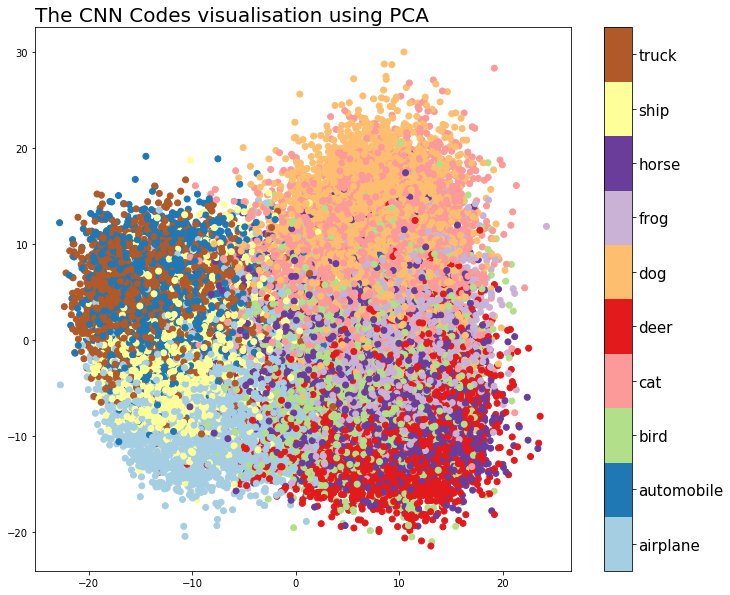

In [25]:
plt.figure(figsize=(12, 10))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap=plt.get_cmap('Paired', 10),
               vmin=-0.5, vmax=9.5)
colorbar = plt.colorbar(ticks=np.arange(0,10))
colorbar.ax.set_yticklabels(classes_names, fontsize=15)
plt.title('The CNN Codes visualisation using PCA', loc='left', fontsize=20)
plt.show()

The classes don't look easily separable. As expected there are pairs of classes, which contain visually similar objects:

- truck and automobile
- ship and airplane (water is similiar to sky)
- horse nad deer
- dog and cat

# 6. SVM classifier on top of the CNN Codes

To choose best model for each neural network, we will use random search with 4-fold cross-validation on whole training set to select best hyper-parameters. Due to computation time of SVM with Gaussian kernel we will focus on SVM with linear kernel. `StandardScaler` will be used to standardize data.

In [26]:
def display_scores(scores):
    order = np.array([x for x in scores.cv_results_.get('rank_test_score')]) - 1
    order = order.argsort()
    params = np.array([x for x in scores.cv_results_.get('params')])
    params = params[order]
    mean_scores = scores.cv_results_.get('mean_test_score')[order]
    std_scores = scores.cv_results_.get('std_test_score')[order]
    for x, y, z in zip(params, mean_scores, std_scores):
        print('params: {}, cv mean: {:.4f}, cv std: {:.4f}'.format(x,y,z))

In [27]:
svm_pipe = Pipeline([('standard_scaler', StandardScaler()), ('svm', LinearSVC())])
params = {'svm__C': np.arange(0.01, 1.001, 0.01)}
search = RandomizedSearchCV(svm_pipe, params, n_iter=10,  n_jobs=10,
                            scoring=make_scorer(accuracy_score), cv=4,
                            verbose=3, random_state=6)
cv_scores = search.fit(X_train_visual_features, y_train)

Fitting 4 folds for each of 10 candidates, totalling 40 fits
[CV] svm__C=0.18000000000000002 ......................................
[CV] svm__C=0.18000000000000002 ......................................
[CV] svm__C=0.18000000000000002 ......................................
[CV] svm__C=0.18000000000000002 ......................................
[CV] svm__C=0.35000000000000003 ......................................
[CV] svm__C=0.35000000000000003 ......................................
[CV] svm__C=0.35000000000000003 ......................................
[CV] svm__C=0.35000000000000003 ......................................
[CV] svm__C=0.01 .....................................................
[CV] svm__C=0.01 .....................................................
[CV] ....................... svm__C=0.01, score=0.90256, total= 5.2min
[CV] svm__C=0.01 .....................................................
[CV] ....................... svm__C=0.01, score=0.90064, total= 5.2min
[CV] svm__C=0.01

[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed: 10.7min


[CV] ....................... svm__C=0.46, score=0.87712, total= 6.2min
[CV] svm__C=0.87 .....................................................
[CV] ....................... svm__C=0.61, score=0.87624, total= 6.0min
[CV] svm__C=0.87 .....................................................
[CV] ........................ svm__C=0.61, score=0.8708, total= 6.1min
[CV] svm__C=0.21000000000000002 ......................................
[CV] .......................... svm__C=0.46, score=0.87, total= 6.4min
[CV] svm__C=0.21000000000000002 ......................................
[CV] ....................... svm__C=0.61, score=0.87144, total= 6.2min
[CV] svm__C=0.21000000000000002 ......................................
[CV] ......................... svm__C=0.46, score=0.874, total= 6.4min
[CV] ....................... svm__C=0.61, score=0.86944, total= 6.2min
[CV] svm__C=0.21000000000000002 ......................................
[CV] svm__C=0.48000000000000004 ......................................
[CV] .

[Parallel(n_jobs=10)]: Done  35 out of  40 | elapsed: 24.6min remaining:  3.5min


[CV] ....................... svm__C=0.45, score=0.87152, total= 5.6min
[CV] ......... svm__C=0.8200000000000001, score=0.87488, total= 5.8min
[CV] .......... svm__C=0.8200000000000001, score=0.8692, total= 5.9min
[CV] ......... svm__C=0.8200000000000001, score=0.87336, total= 5.7min
[CV] ......... svm__C=0.8200000000000001, score=0.87128, total= 5.8min


[Parallel(n_jobs=10)]: Done  40 out of  40 | elapsed: 25.1min finished


In [28]:
display_scores(cv_scores)

params: {'svm__C': 0.01}, cv mean: 0.9018, cv std: 0.0015
params: {'svm__C': 0.18000000000000002}, cv mean: 0.8777, cv std: 0.0021
params: {'svm__C': 0.21000000000000002}, cv mean: 0.8768, cv std: 0.0021
params: {'svm__C': 0.35000000000000003}, cv mean: 0.8748, cv std: 0.0027
params: {'svm__C': 0.45}, cv mean: 0.8737, cv std: 0.0023
params: {'svm__C': 0.48000000000000004}, cv mean: 0.8731, cv std: 0.0028
params: {'svm__C': 0.46}, cv mean: 0.8730, cv std: 0.0028
params: {'svm__C': 0.8200000000000001}, cv mean: 0.8722, cv std: 0.0021
params: {'svm__C': 0.61}, cv mean: 0.8720, cv std: 0.0026
params: {'svm__C': 0.87}, cv mean: 0.8719, cv std: 0.0021


ResNet50 - LinearSVC random search results:

params: {'svm__C': 0.01}, cv mean: 0.9018, cv std: 0.0015  
params: {'svm__C': 0.18}, cv mean: 0.8777, cv std: 0.0021  
params: {'svm__C': 0.21}, cv mean: 0.8768, cv std: 0.0021  
params: {'svm__C': 0.35}, cv mean: 0.8748, cv std: 0.0027  
params: {'svm__C': 0.45}, cv mean: 0.8737, cv std: 0.0023  
params: {'svm__C': 0.48}, cv mean: 0.8731, cv std: 0.0028  
params: {'svm__C': 0.46}, cv mean: 0.8730, cv std: 0.0028  
params: {'svm__C': 0.82}, cv mean: 0.8722, cv std: 0.0021  
params: {'svm__C': 0.61}, cv mean: 0.8720, cv std: 0.0026  
params: {'svm__C': 0.87}, cv mean: 0.8719, cv std: 0.0021   

VGG19 with average pooling - LinearSVC random search results:  

params: {'svm__C': 0.01}, cv mean: 0.8665, cv std: 0.0014  
params: {'svm__C': 0.18}, cv mean: 0.8656, cv std: 0.0022  
params: {'svm__C': 0.21}, cv mean: 0.8652, cv std: 0.0020  
params: {'svm__C': 0.46}, cv mean: 0.8644, cv std: 0.0019  
params: {'svm__C': 0.35}, cv mean: 0.8644, cv std: 0.0025  
params: {'svm__C': 0.48}, cv mean: 0.8643, cv std: 0.0017  
params: {'svm__C': 0.45}, cv mean: 0.8642, cv std: 0.0029  
params: {'svm__C': 0.61}, cv mean: 0.8627, cv std: 0.0012  
params: {'svm__C': 0.82}, cv mean: 0.8618, cv std: 0.0028  
params: {'svm__C': 0.87}, cv mean: 0.8604, cv std: 0.0013  

VGG19 with max pooling - LinearSVC random search results:  

params: {'svm__C': 0.01}, cv mean: 0.8485, cv std: 0.0018  
params: {'svm__C': 0.18}, cv mean: 0.8478, cv std: 0.0008  
params: {'svm__C': 0.21}, cv mean: 0.8475, cv std: 0.0008  
params: {'svm__C': 0.35}, cv mean: 0.8471, cv std: 0.0011  
params: {'svm__C': 0.45}, cv mean: 0.8469, cv std: 0.0003  
params: {'svm__C': 0.46}, cv mean: 0.8467, cv std: 0.0010  
params: {'svm__C': 0.48}, cv mean: 0.8463, cv std: 0.0008  
params: {'svm__C': 0.61}, cv mean: 0.8443, cv std: 0.0003  
params: {'svm__C': 0.82}, cv mean: 0.8420, cv std: 0.0022  
params: {'svm__C': 0.87}, cv mean: 0.8394, cv std: 0.0025   

# 7. Evaluation of final model on the test set

In [29]:
start_time = time.time()
best_model = cv_scores.best_estimator_
best_model.fit(X_train_visual_features, y_train)
y_pred = best_model.predict(X_test_visual_features)
accuracy = accuracy_score(y_test, y_pred)
computation_time = time.time() - start_time
print('LinearSVC(C={}): accuracy_score = {}, computation_time = {:.2f}min.'.format(best_model.get_params()['svm__C'],
                                                                                   accuracy, computation_time / 60))

LinearSVC(C=0.01): accuracy_score = 0.9081, computation_time = 4.85min.


ResNet50 - LinearSVC:  
LinearSVC(C=0.01): accuracy_score = 0.9081, computation_time = 4.85min.  

VGG19 with average pooling - LinearSVC:  
LinearSVC(C=0.01): accuracy_score = 0.8652, computation_time = 1.63min.

VGG19 with max pooling - LinearSVC:  
LinearSVC(C=0.01): accuracy_score = 0.8476, computation_time = 1.43min.  

All results are similar to crossvalidation results.

In [30]:
error_matrix = confusion_matrix(y_test, y_pred)
print(classes_names)
print(error_matrix)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
[[915   9   9   3   6   3   2   7  37   9]
 [  4 954   2   3   1   2   2   2   5  25]
 [ 16   1 877  22  36   7  25  12   2   2]
 [ 10   3  20 818  23  73  29  15   5   4]
 [  5   4  21  20 901   5  17  25   1   1]
 [  2   0   7  68  16 871  10  21   3   2]
 [  4   0  24  22   8   2 938   2   0   0]
 [  4   0   6   8  28  19   1 931   2   1]
 [ 29   4   3   2   1   1   0   1 950   9]
 [ 11  40   2   7   0   1   1   2  10 926]]


In [31]:
print(classification_report(y_test, y_pred, target_names=classes_names))

             precision    recall  f1-score   support

   airplane       0.92      0.92      0.92      1000
 automobile       0.94      0.95      0.95      1000
       bird       0.90      0.88      0.89      1000
        cat       0.84      0.82      0.83      1000
       deer       0.88      0.90      0.89      1000
        dog       0.89      0.87      0.88      1000
       frog       0.92      0.94      0.93      1000
      horse       0.91      0.93      0.92      1000
       ship       0.94      0.95      0.94      1000
      truck       0.95      0.93      0.94      1000

avg / total       0.91      0.91      0.91     10000



Summing up, cats' images seems to be hardest to predict correctly. As it was said before, there are pairs of classes with visually similar images, which is confirmed by incorrect predictions between these classes.

Our best model based on ResNet50 obtained accuracy about 90.81%, which is much higher than accuracy for HoG SVM.

# 8. Bonus task

Finally, let's find out if we can improve score by ensemble modeling. We will try majority voting method for our three models based on `Resnet50` and `VGG-19`.

In [32]:
def majority_voting(predictions):
    majority_pred = []
    for x in predictions:
        votes = np.zeros(10)
        for vote in x:
            votes[vote] += 1
        if all((votes == 1) | (votes == 0)):
            majority_pred.append(x[2]) #if draw choose resnet50
        else:
            majority_pred.append(votes.argmax())
    return majority_pred

In [33]:
data_folder = './data/cifar-10-batches-py/'
_, y_train, _, y_test, _ = load_data(data_folder)
visual_features = [{'X_train': np.load('./data/X_train_visual_features_vgg19_ave.npy'),
                    'X_test': np.load('./data/X_test_visual_features_vgg19_ave.npy')},
                   {'X_train': np.load('./data/X_train_visual_features_vgg19_max.npy'),
                    'X_test': np.load('./data/X_test_visual_features_vgg19_max.npy')},
                   {'X_train': np.load('./data/X_train_visual_features_resnet50.npy'),
                    'X_test': np.load('./data/X_test_visual_features_resnet50.npy')}]

In [34]:
scaler = StandardScaler()
svc = LinearSVC()
model_pipe = Pipeline([('standard_scaler', scaler), ('svm', svc)])

best_C = [0.01, 0.01, 0.01] #vgg19_ave, vvg19_max, resnet50
predictions = np.zeros((10000, 3), dtype='int')
computation_times = []

for i in np.arange(3):
    start_time = time.time()
    model_pipe.set_params(svm__C=best_C[i]).fit(visual_features[i]['X_train'], y_train)
    y_pred = model_pipe.predict(visual_features[i]['X_test'])
    predictions[:, i] = y_pred
    computation_times.append(time.time() - start_time)
    sys.stdout.write("\r%d/%d models done" % (i + 1, 3))
    sys.stdout.flush()
    
majority_pred = majority_voting(predictions)
vgg19_ave_accuracy = accuracy_score(y_test, predictions[:, 0])
vgg19_max_accuracy = accuracy_score(y_test, predictions[:, 1])
resnet50_accuracy = accuracy_score(y_test, predictions[:, 2])
majority_accuracy = accuracy_score(y_test, majority_pred)

print('\n\nResults:\n')
print('VGG-19 average pooling SVM: accuracy_score = {}, computation_time = {:.2f}min.'.\
      format(vgg19_ave_accuracy, computation_times[0] / 60))
print('VGG-19 max pooling SVM: accuracy_score = {}, computation_time = {:.2f}min.'.\
      format(vgg19_max_accuracy, computation_times[1] / 60))
print('Resnet50 SVM: accuracy_score = {}, computation_time = {:.2f}min.'.\
      format(resnet50_accuracy, computation_times[2] / 60))
print('Majority voting: accuracy_score = {}, computation_time = {:.2f}min.'.\
      format(majority_accuracy, np.sum(computation_times) / 60))

3/3 models done

Results:

VGG-19 average pooling SVM: accuracy_score = 0.8652, computation_time = 1.66min.
VGG-19 max pooling SVM: accuracy_score = 0.8476, computation_time = 1.42min.
Resnet50 SVM: accuracy_score = 0.9081, computation_time = 5.26min.
Majority voting: accuracy_score = 0.8887, computation_time = 8.34min.


As we see, we didn't obtain better accuracy (88.87%) than single best model (90.81%).